# Un interprete iterativo

In [ ]:
from collections import defaultdict

from liblet import ANTLR, Tree, Stack, AnnotatedTreeWalker, iter2table, warn

from L22 import SimpleBlockLang, simpleBlock2ast

## Code Threading

Seguendo l'approcco di MCD 5.1 e usando `SimpleBlockLang` come esempio, vediamo come fare il *threding* dei tre costrutti fondamentali: sequenza, selezione ed iterazione.

Al solito usiamo un `AnnotatedTreeWalker` per analizzare l'AST, ci serviremo di due variabili globali `THREADS` (un dizionario dai nodi dell'AST a dei dizionari che conserveranno una mappa tra nomi di "salto" e i nodi a cui "saltare") e `LAST` (un riferimento all'ultimo nodo analizzato).

In [ ]:
thread = AnnotatedTreeWalker('type')
LAST = None
THREADS = None

Un paio di funzioni: la prima per effettuare il threading e la seconda per raccogliere convenientemente i passi di compilazione, produzione dell'AST, threading e visualizzazione.

In [ ]:
def do_thread(ast):
    
    global LAST, THREADS

    THREADS = defaultdict(dict)
    START = Tree({'type': '<START>'})
    LAST = START
    thread(ast)
    THREADS[LAST]['next'] = None 
    
def show_threads(source):
    ptree = SimpleBlockLang.tree(source, 'program')
    ast = simpleBlock2ast(ptree)
    do_thread(ast)
    return ast.with_threads(THREADS)

### Sequenza

Per gestire la sequenza (che coinvolge tutti i nodi fatti salvi quelli di selezione ed iterazione) è sufficiente un catch-all che scarichi ricorsivamente e colleghi ogni nodo al successivo.

In [ ]:
@thread.catchall
def catchall(visit, ast):

    global LAST

    for child in ast.children: visit(child)
    THREADS[LAST]['next'] = ast
    LAST = ast

Vediamo un esempio

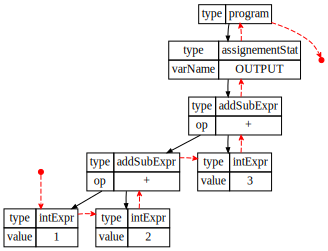

In [ ]:
show_threads("""
OUTPUT = 1 + 2 + 3;
""")

#### Sistemiamo i blocchi

Va sistemato il fatto che il catch-all torna al blocco

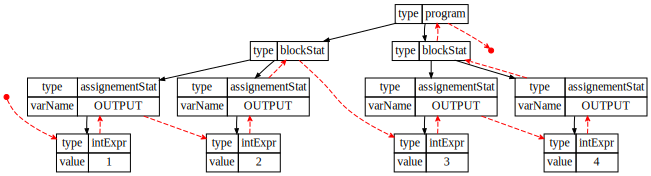

In [ ]:
source = """
{ OUTPUT = 1; OUTPUT = 2; }
{ OUTPUT = 3; OUTPUT = 4; }
"""
show_threads(source)

Basta evitare di riportare l'ultimo nodo verso il blocco (le ultime due righe del catch-all)

In [ ]:
@thread.register
def blockStat(visit, ast):
    
    global LAST
    
    for child in ast.children: visit(child)

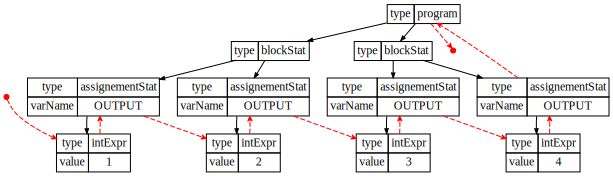

In [ ]:
show_threads(source)

### Selezione

Per la selzione è necessario creare un nodo di tipo `<JOIN>` per mettere assieme i due thread del ramo "true" e "false" nonché sostituire l'usuale salto `next` con un salto per ramo.

In [ ]:
@thread.register
def ifElseStat(visit, ast):
    
    global LAST

    expr, true, false = ast.children

    join = Tree({'type': '<JOIN>'})
    temp = Tree('temp')

    visit(expr)
    THREADS[LAST]['next'] = ast
    #LAST = ast

    LAST = temp
    visit(true)
    THREADS[ast]['true'] = THREADS[temp]['next']
    THREADS[LAST]['next'] = join

    LAST = temp
    visit(false)
    THREADS[ast]['false'] = THREADS[temp]['next']
    THREADS[LAST]['next'] = join

    del THREADS[temp]

    LAST = join

Vediamo un esempio

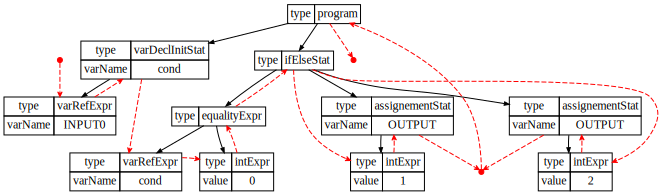

In [ ]:
show_threads("""
var cond = INPUT0;

if cond == 0 then 
    OUTPUT = 1;
else
    OUTPUT = 2;
""")

### Iterazione

Per finire, l'iterazione; non c'è bisogno di un nodo extra, basta usare il salto `next` per il caso in cui l'iterazione sia esaurita, e un salto `repeat` in caso contrario.

In [ ]:
@thread.register
def repeatStat(visit, ast):
    
    global LAST

    count, stat = ast.children

    visit(count)
    THREADS[LAST]['next'] = ast
    LAST = ast

    visit(stat)
    THREADS[ast]['repeat'] = THREADS[ast]['next']
    THREADS[LAST]['next'] = ast

    LAST = ast

Un piccolo esempio

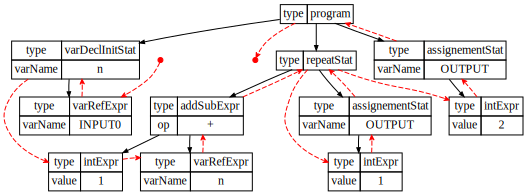

In [ ]:
show_threads("""
var n = INPUT0;
repeat 1 + n times 
    OUTPUT = 1;
OUTPUT = 2;
""")

## Un esempio completo

Vediamo un esempio completo, che usremo nella costruzione dell'interprete. Contiene un campionario delle possibili istruzioni ed operazioni…

In [ ]:
# se INPUT0 è 0 restituisce 2 * INPUT1, altrimenti restituisce 123456

source = """
var sel = INPUT0;
var n = INPUT1;

var res;

if sel == 0 then {
    res = 0;
    repeat n times
        res = res + 2;
} else 
    res = 123456;
    
OUTPUT = res;
"""

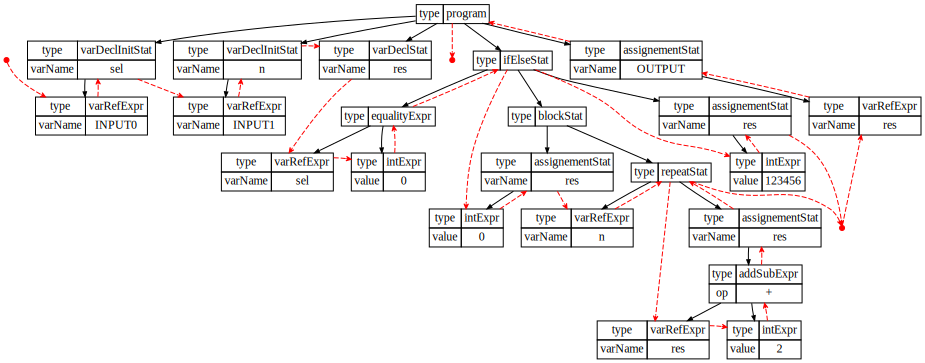

In [ ]:
show_threads(source)

## Interprete

### Istruzioni e salti

Per prima cosa, semplifichiamo `THREADS` tenendo da parte solo le istruzioni ed i salti, iniziamo col trasformare ogni nodo (da usare nei salti) in un numero progressivo, dopo aver numerato i nodi…

In [ ]:
NODES = list(THREADS.keys())

def node2num(node):
    return NODES.index(node)

Ora ricaviamo i salti

In [ ]:
JUMPS = []
for info in THREADS.values():
    JUMPS.append(
        {name: node2num(node) if node is not None else None for name, node in info.items()}
    )

Le "istruzioni" (conserviamo solo le radici dei nodi), osservate che condividono la numerazione dei nodi (perché sono ricavati iterando la loro lista)

In [ ]:
INSTRS = [node.root for node in NODES]

Riassumiamo le informazioni estratte (osservate che gli indici della tabella sono i numeri dei nodi e delle istruzioni)…

In [ ]:
iter2table(zip(INSTRS, JUMPS))

### L'interprete iterativo

Per costruire l'interprete ci serve uno `STACK` dove conservare il risultato intermedio delle operazioni e una `GLOBAL_MEMORY` per memorizzare le variabili globali (qui per semplicità non ci occupiamo dello scoping di blocco).

In [ ]:
def interpreter(indct, trace = False):

    GLOBAL_MEMORY = indct.copy()
    STACK = Stack()
    IP = 0
    while True:

        # Fetch
        
        instr = INSTRS[IP]
        jump = JUMPS[IP]
        
        # Siamo alla fine?
        
        if 'next' in jump and jump['next'] == None: break    

        # Tracing
        if trace: print(IP, instr, jump, STACK)
        
        # Decoding ed esecuzione
        
        IP = None
        
        if instr['type'] == 'intExpr':
            STACK.push(instr['value'])

        elif instr['type'] == 'addSubExpr':
            if instr['op'] == '-':
                STACK.push(-STACK.pop() + STACK.pop())
            elif instr['op'] == '+':
                STACK.push(STACK.pop() + STACK.pop())

        elif instr['type'] == 'equalityExpr':
            STACK.push(STACK.pop() == STACK.pop())
                
        elif instr['type'] == 'varRefExpr':
            STACK.push(GLOBAL_MEMORY[instr['varName']])
            
        elif instr['type'] == 'varDeclInitStat':
            GLOBAL_MEMORY[instr['varName']] = STACK.pop()
            
        elif instr['type'] == 'varDeclStat':
            GLOBAL_MEMORY[instr['varName']] = None
            
        elif instr['type'] == 'assignementStat':
            GLOBAL_MEMORY[instr['varName']] = STACK.pop()
            
        elif instr['type'] == 'ifElseStat':
            IP = jump['true'] if STACK.pop() else jump['false']
                        
        elif instr['type'] == 'repeatStat':
            count = STACK.pop()
            if count > 0:
                STACK.push(count - 1)
                IP = jump['repeat']
            else:
                IP = jump['next']

        elif instr['type'] in ('<START>', '<JOIN>'):
            pass # ingoro l'inizio e i join
            
        else:
            # ma emetto warning per le istruzioni
            # di cui questa implementazione parziale 
            # ancora non si occupa
            
            warn('ignoring: ' + instr['type'])
                
        # se selezione o iterazione non hanno riassegnato IP, passo al `next`         
        if IP is None: IP = jump['next']
    
    return GLOBAL_MEMORY['OUTPUT']

Eseguiamo il ramo false

In [ ]:
interpreter({'INPUT0': 1, 'INPUT1': 3}, True)    

0 {'type': '<START>'} {'next': 1} Stack()
1 {'type': 'varRefExpr', 'varName': 'INPUT0'} {'next': 2} Stack()
2 {'type': 'varDeclInitStat', 'varName': 'sel'} {'next': 3} Stack(1 ↔)
3 {'type': 'varRefExpr', 'varName': 'INPUT1'} {'next': 4} Stack()
4 {'type': 'varDeclInitStat', 'varName': 'n'} {'next': 5} Stack(3 ↔)
5 {'type': 'varDeclStat', 'varName': 'res'} {'next': 6} Stack()
6 {'type': 'varRefExpr', 'varName': 'sel'} {'next': 7} Stack()
7 {'type': 'intExpr', 'value': 0} {'next': 8} Stack(1 ↔)
8 {'type': 'equalityExpr'} {'next': 17} Stack(1, 0 ↔)
17 {'type': 'ifElseStat'} {'true': 9, 'false': 18} Stack(False ↔)
18 {'type': 'intExpr', 'value': 123456} {'next': 19} Stack()
19 {'type': 'assignementStat', 'varName': 'res'} {'next': 20} Stack(123456 ↔)
20 {'type': '<JOIN>'} {'next': 21} Stack()
21 {'type': 'varRefExpr', 'varName': 'res'} {'next': 22} Stack()
22 {'type': 'assignementStat', 'varName': 'OUTPUT'} {'next': 23} Stack(123456 ↔)


123456

E ora quello true…

In [ ]:
interpreter({'INPUT0': 0, 'INPUT1': 4})    

8

# <span style="color: red;"> Esercizi per casa </span>

Queste proposte sono assolutamente propedeutiche alla costruzione dell'interprete iterativo per "Tiny HI.

* Aggiustate `thread` per il caso degli `if` senza `else`. 

* Modificate la grammatica aggiungendo le regole per una iterazione unbounded tipo *ciclo while* secondo la sintassi `while <expr> do <stat>` (dove `while` e `do` sono due nuovi *token* e con `<expr>` e `<stat>` sono indicate le due *rule* già esistenti; verificate che il parsing funzioni con un nuovo pezzo di codice comprendente un ciclo.

* Modificate la generazione dell'AST perché tenga conto del *while*.

* Modificate la funzione `thread` perché tenga conto del *while*.

* Modificate l'interprete perché tenga conto del ciclo *while*.

* Sapreste estendere `thread` e interprete per gestire lo scope di blocco?

* Sapreste estendere `thread` e interprete per gestire le funzioni?